Tyler Becker

In [1]:
import pandas as pd
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from scipy.ndimage import convolve
import scipy

In [2]:
N = 100
m = N
L = 5
h = np.array([np.exp(-np.square(x)/2) for x in range(-2,3)])
x = np.zeros(N)
x[[9,12,49,69]] = [1, -1, 0.3, 0.2]

# 1

In [3]:
def unit_basis(i, N):
    b = np.zeros(N)
    b[i] = 1
    return b

def blur(x):
    return convolve(x, h, mode='wrap')

def implicit2explicit(f, N):
    m = len(f(unit_basis(0,N)))
    B = np.zeros((m, N))
    for i in range(N):
        b = unit_basis(i,N)
        B[i,:] = f(b)
    return B

In [4]:
B = implicit2explicit(blur, N)
all((B @ x) == blur(x)) # True

True

# 2

In [5]:
sigma = 0.02
eps = sigma * np.sqrt(N)
y = B @ x + np.random.randn(N) * sigma
X = cvx.Variable(N)
obj = cvx.Minimize(cvx.norm1(X))
prob = cvx.Problem(obj, [cvx.norm2(B@X - y)**2 <= eps**2])
prob.solve()
x_hat = X.value

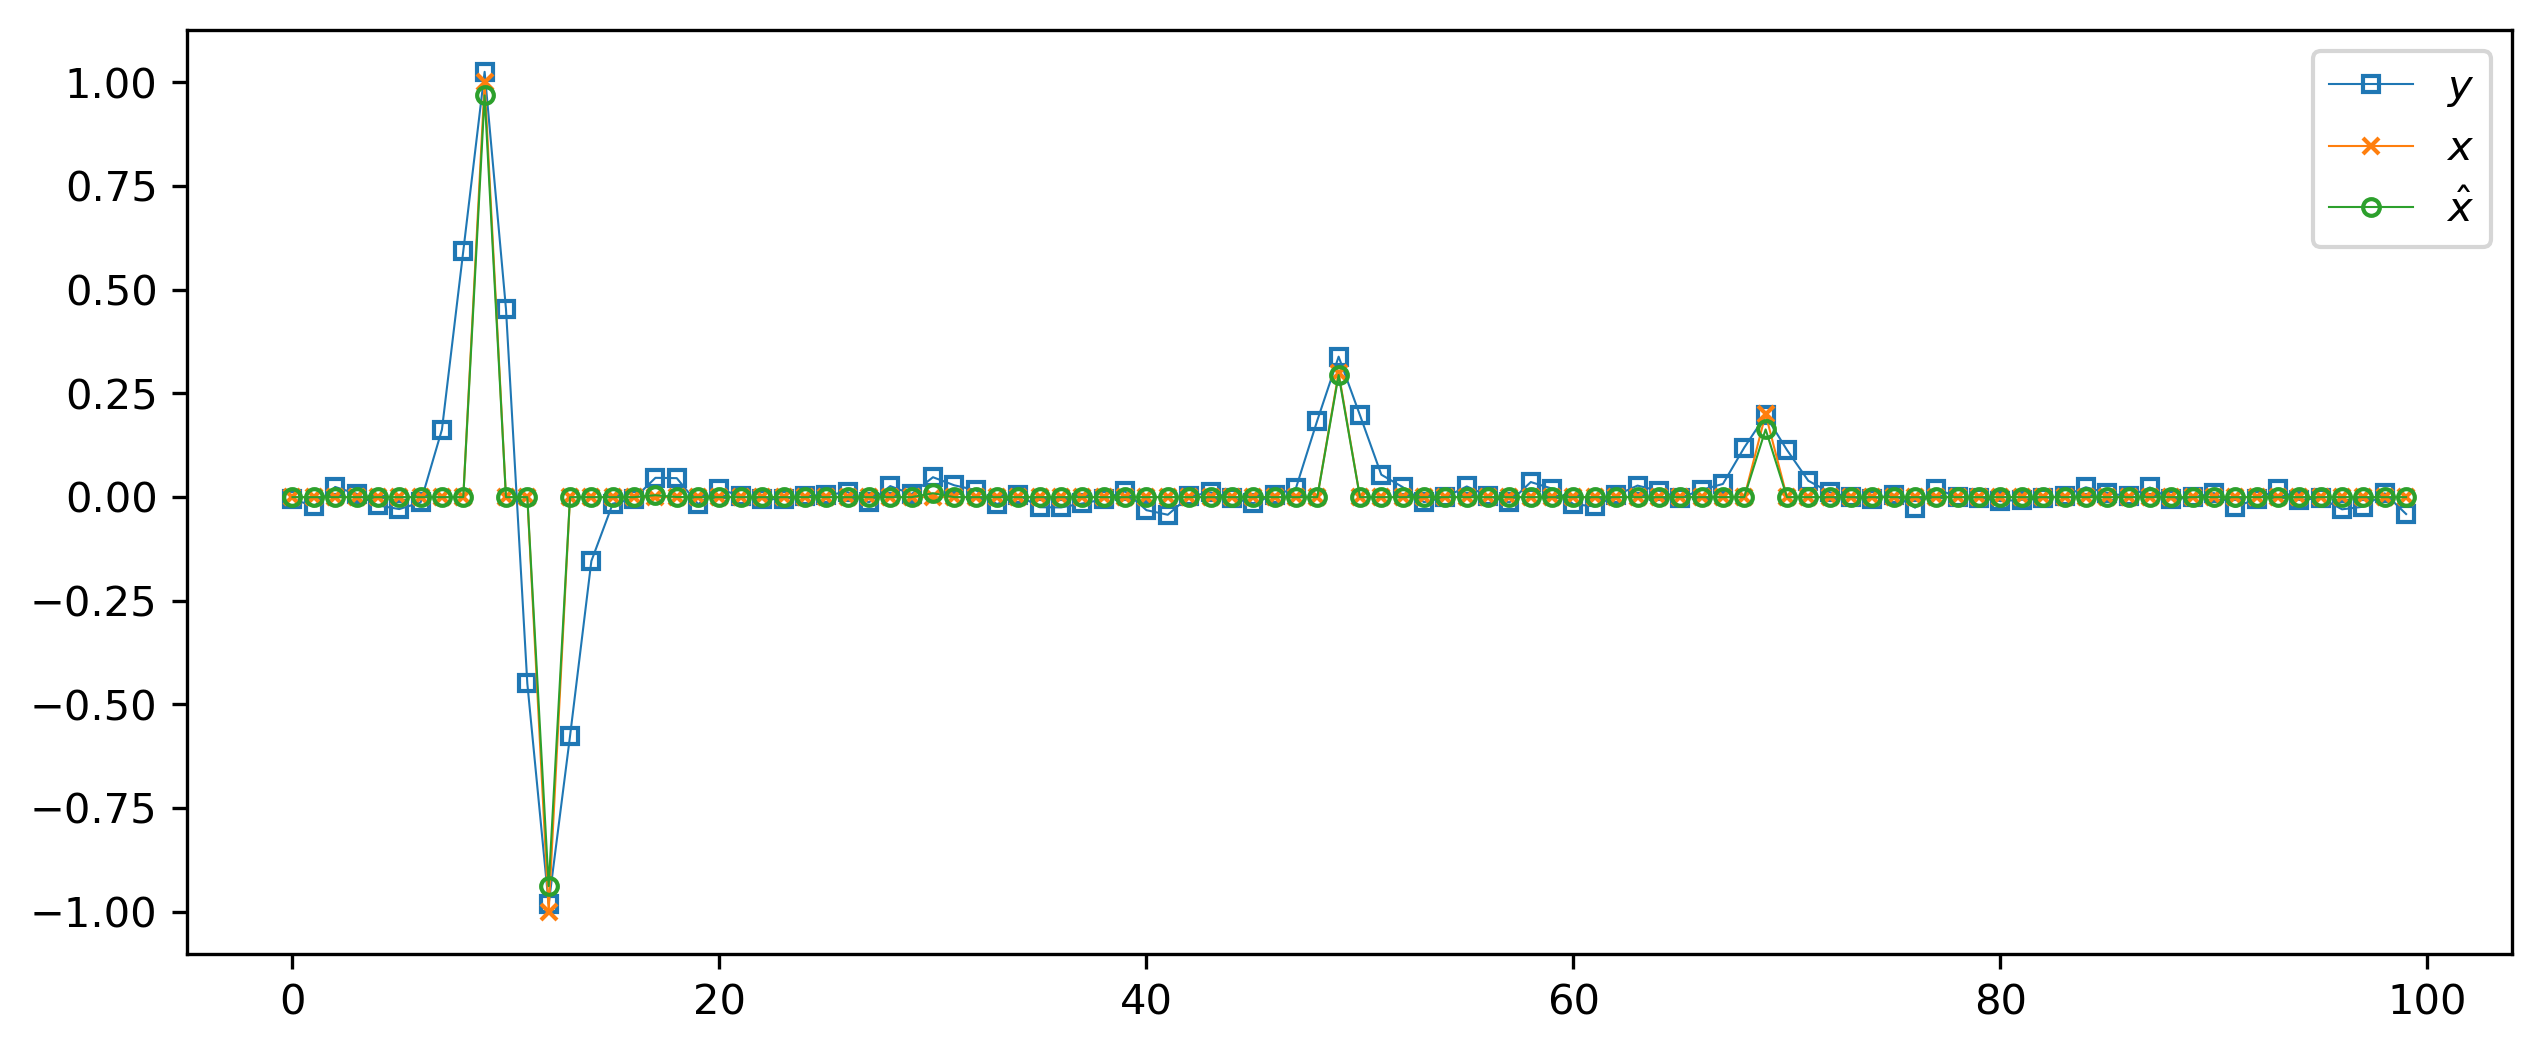

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(y, label="$y$", marker='s', markersize=4, fillstyle='none', lw=0.5)
ax.plot(x, label="$x$", marker='x', markersize=4, fillstyle='none', lw=0.5)
ax.plot(x_hat, label="$\hat{x}$", marker='o', markersize=4, fillstyle='none', lw=0.5)
ax.legend()
plt.show()

# 3

In [7]:
X2 = cvx.Variable(N)
_lambda = prob.constraints[0].dual_value
prob2 = cvx.Problem(
    cvx.Minimize(
        cvx.norm1(X2) + _lambda*cvx.norm2(B @ X2 - y)**2
    )
)
prob2.solve()

2.719031681415343

In [8]:
np.linalg.norm(X2.value - X.value, 2)

2.2141152636848517e-06

# 4

In [9]:
def input_pad(x,h):
    half = (len(h)-1) // 2
    return np.concatenate((x[-half:], x, x[:half]))

def B_func(x, h=h):
    n = len(x)
    m = len(h)
    x_pad = input_pad(x,h)
    h_pad = np.pad(h, (0,n-1))
    return scipy.fft.irfft(scipy.fft.rfft(x_pad) * scipy.fft.rfft(h_pad))[m-1:]

def B_func_adj(x, h=h):
    n = len(x)
    m = len(h)
    x_pad = input_pad(x, h)
    h_pad = np.pad(h, (0,n-1))
    step1 = scipy.fft.rfft(x_pad)
    h_hat = scipy.fft.rfft(h_pad)
    h_hat_bar = np.conjugate(h_hat)
    step2 = h_hat_bar * step1
    return scipy.fft.irfft(step2)[:-(m-1)]

def test_adjoint(f, f_adj, x=np.random.rand(100), y=np.random.rand(100), tol=1e-8):
    return abs(np.vdot(f(x), y) - np.vdot(x, f_adj(y))) < tol

def test_adjoint_mat(A, A_adj, x=np.random.rand(100), y=np.random.rand(100), tol=1e-8):
    return abs(np.vdot(A_adj @ x, y) - np.vdot(x, A_adj @ y)) < tol

In [10]:
Bs = B.conjugate().T
print(test_adjoint_mat(B, Bs)) # True
print(test_adjoint(B_func, B_func_adj)) # True

True
True


# 5

In [11]:
import firstOrderMethods

In [12]:
tau = 1 / (2*_lambda)
X = cvx.Variable(N)
prob = cvx.Problem(
    cvx.Minimize(
        tau*cvx.norm1(X) + 0.5*cvx.sum_squares(B@X - y)
    )
)
prob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 16 12:06:43 PM: Your problem has 100 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 16 12:06:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 16 12:06:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 16 12:06:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 16 12:06:43 PM: Compiling problem (target solver=OSQP).
(CVXPY) Feb 16 12:06:43 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffin

0.16013152888718152

In [13]:
x_hat, data = firstOrderMethods.lassoSolver(A=B_func,b=y,tau=tau, At=B_func_adj)

Iter.  Objective Stepsize
-----  --------- --------
    0  2.14e+00  1.42e-01
   50  1.60e-01  1.42e-01
Iter 50 Quitting due to stagnating objective value


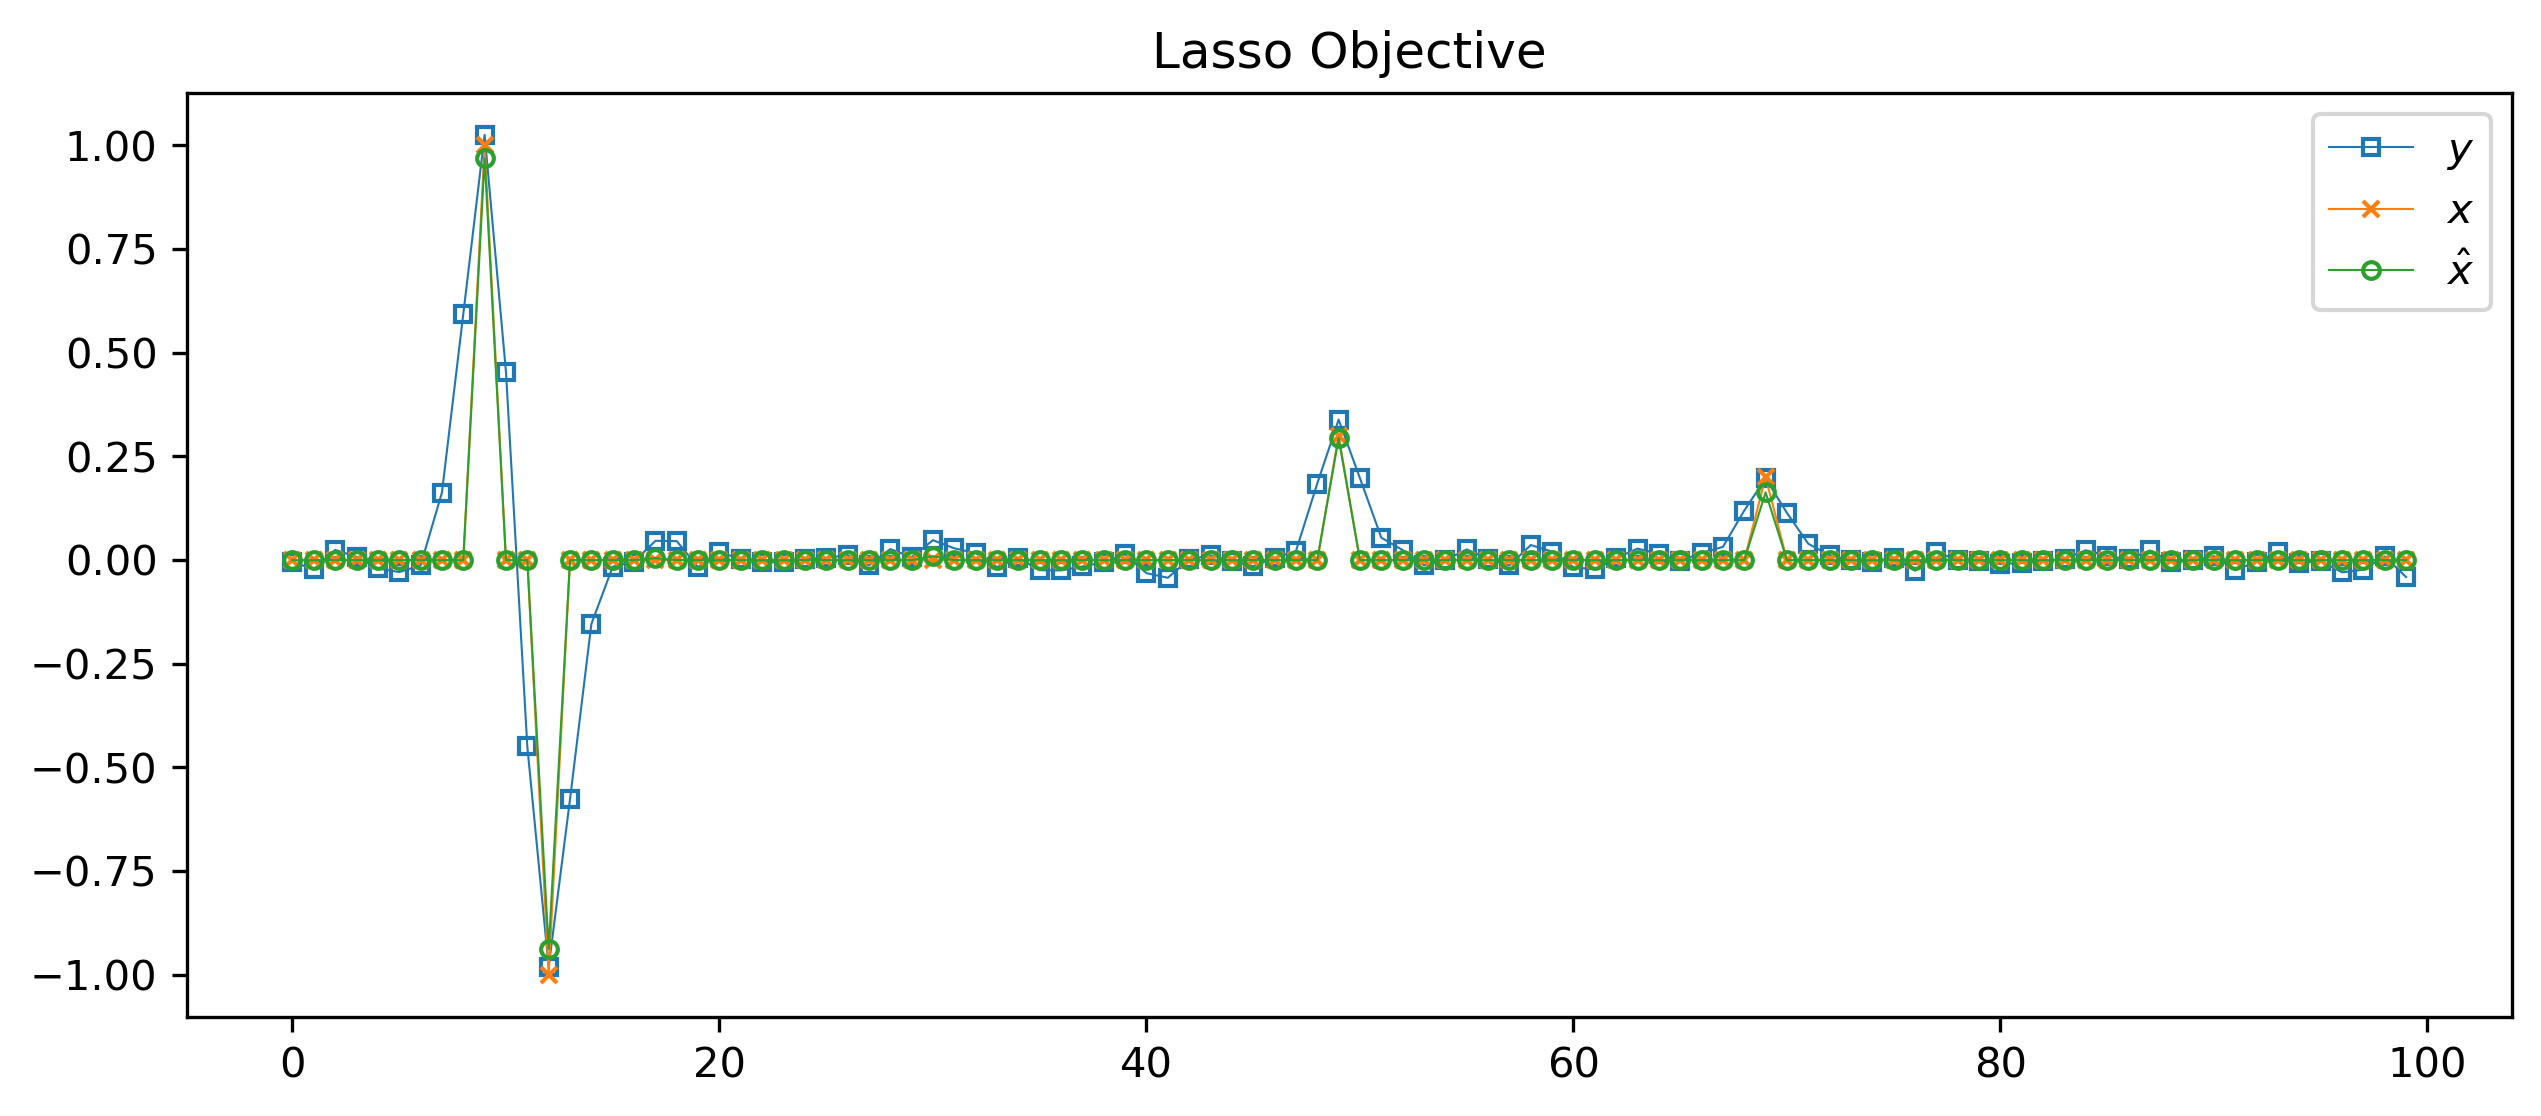

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(y, label="$y$", marker='s', markersize=4, fillstyle='none', lw=0.5)
ax.plot(x, label="$x$", marker='x', markersize=4, fillstyle='none', lw=0.5)
ax.plot(x_hat, label="$\hat{x}$", marker='o', markersize=4, fillstyle='none', lw=0.5)
ax.set_title('Lasso Objective')
ax.legend()
plt.show()